In [83]:
from pathlib import Path
import duckdb
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from func import print_stats, Preprocess

In [84]:
path = Path.home() / 'OneDrive - Seagroup/ai/kaggle_dataset/child-mind-institute-detect-sleep-states'

# 1. Test Data

In [85]:
file = next(path.glob('test*.parquet'))
query = f"""select * from read_parquet('{file}') limit 5"""
duckdb.sql(query)

┌──────────────┬────────┬──────────────────────────┬────────┬────────┐
│  series_id   │  step  │        timestamp         │ anglez │  enmo  │
│   varchar    │ uint32 │         varchar          │ float  │ float  │
├──────────────┼────────┼──────────────────────────┼────────┼────────┤
│ 038441c925bb │      0 │ 2018-08-14T15:30:00-0400 │ 2.6367 │ 0.0217 │
│ 038441c925bb │      1 │ 2018-08-14T15:30:05-0400 │ 2.6368 │ 0.0215 │
│ 038441c925bb │      2 │ 2018-08-14T15:30:10-0400 │  2.637 │ 0.0216 │
│ 038441c925bb │      3 │ 2018-08-14T15:30:15-0400 │ 2.6368 │ 0.0213 │
│ 038441c925bb │      4 │ 2018-08-14T15:30:20-0400 │ 2.6368 │ 0.0215 │
└──────────────┴────────┴──────────────────────────┴────────┴────────┘

# 2. Train Data

In [134]:
# csv
file_csv = next(path.glob('train*.csv'))
query = f"""select * from read_csv_auto('{file_csv}') where timestamp is not null"""
df_csv = duckdb.sql(query)
print(df_csv.shape, df_csv.columns)

# parquet 
file_parquet = next(path.glob('train*.parquet'))
query = f"""select series_id 
, step
, anglez
, enmo
, strptime(timestamp, '%Y-%m-%dT%H:%M:%S%z') as timestamp
from read_parquet('{file_parquet}')"""
df_parquet = duckdb.sql(query)
print(df_parquet.shape, df_parquet.columns)

# merge
query = f"""
select c.*
, p.step step_right
, p.anglez
, p.enmo
from df_csv c 
left join df_parquet p on p.series_id = c.series_id and p.timestamp = c.timestamp
"""
df_merge = duckdb.sql(query)
print(df_merge.shape)

(9587, 5) ['series_id', 'night', 'event', 'step', 'timestamp']
(127946340, 5) ['series_id', 'step', 'anglez', 'enmo', 'timestamp']
(9587, 8)


In [135]:
df_merge

┌──────────────┬───────┬─────────┬────────┬─────────────────────┬────────────┬──────────┬────────┐
│  series_id   │ night │  event  │  step  │      timestamp      │ step_right │  anglez  │  enmo  │
│   varchar    │ int64 │ varchar │ int64  │      timestamp      │   uint32   │  float   │ float  │
├──────────────┼───────┼─────────┼────────┼─────────────────────┼────────────┼──────────┼────────┤
│ 0a96f4993bd7 │    15 │ wakeup  │ 256260 │ 2018-05-18 10:25:00 │     251220 │ -70.1726 │    0.0 │
│ 0cd1e3d0ed95 │     1 │ onset   │   5484 │ 2017-12-09 03:37:00 │        444 │  -2.3472 │ 0.1728 │
│ 0cd1e3d0ed95 │     1 │ wakeup  │   9432 │ 2017-12-09 09:06:00 │       4392 │ -17.5866 │ 0.0099 │
│ 0cd1e3d0ed95 │     2 │ onset   │  23616 │ 2017-12-10 04:48:00 │      18576 │  -0.0675 │ 0.0058 │
│ 0cd1e3d0ed95 │     2 │ wakeup  │  29520 │ 2017-12-10 13:00:00 │      24480 │  10.0548 │ 0.0104 │
│ 0cd1e3d0ed95 │     3 │ onset   │  37836 │ 2017-12-11 00:33:00 │      32796 │ -39.5611 │ 0.0149 │
│ 0cd1e3d0

## 2.1 Check day duration between series_id

In [137]:
query = f"""
with base as 
(
select series_id
, {', '.join([f'{i}(timestamp) {i}_timestamp' for i in ['min', 'max']])}
, count(distinct event) total_event
, count(distinct night) total_night
from df_merge
group by 1
)

select *
, date_diff('day', min_timestamp, max_timestamp) day_diff
from base
"""
df_group = duckdb.query(query)
df_group

┌──────────────┬─────────────────────┬─────────────────────┬─────────────┬─────────────┬──────────┐
│  series_id   │    min_timestamp    │    max_timestamp    │ total_event │ total_night │ day_diff │
│   varchar    │      timestamp      │      timestamp      │    int64    │    int64    │  int64   │
├──────────────┼─────────────────────┼─────────────────────┼─────────────┼─────────────┼──────────┤
│ 062cae666e2a │ 2019-02-02 05:16:00 │ 2019-02-14 12:14:00 │           2 │           3 │       12 │
│ 2cd2340ca14d │ 2018-08-22 07:11:00 │ 2018-09-04 13:47:00 │           2 │          11 │       13 │
│ 3be2f86c3e45 │ 2018-01-18 01:58:00 │ 2018-02-03 13:15:00 │           2 │           4 │       16 │
│ 519ae2d858b0 │ 2018-02-14 03:18:00 │ 2018-03-07 12:18:00 │           2 │           7 │       21 │
│ 601559e1777d │ 2019-03-23 01:06:00 │ 2019-04-23 13:15:00 │           2 │          31 │       31 │
│ 6ee4ade1f2bd │ 2018-02-15 01:22:00 │ 2018-03-09 10:59:00 │           2 │          23 │       22 │


In [140]:
print(df_group['day_diff'].describe(), df_group['total_night'].describe())

┌─────────┬───────────────────┐
│  aggr   │     day_diff      │
│ varchar │      double       │
├─────────┼───────────────────┤
│ count   │             269.0 │
│ mean    │ 20.16728624535316 │
│ stddev  │ 8.384748084699819 │
│ min     │               0.0 │
│ max     │              42.0 │
│ median  │              21.0 │
└─────────┴───────────────────┘
 ┌─────────┬───────────────────┐
│  aggr   │    total_night    │
│ varchar │      double       │
├─────────┼───────────────────┤
│ count   │             269.0 │
│ mean    │ 17.82527881040892 │
│ stddev  │  8.29421397499603 │
│ min     │               1.0 │
│ max     │              35.0 │
│ median  │              19.0 │
└─────────┴───────────────────┘


## 2.2 check events on series_id

In [92]:
df_group['total_event'].describe()

┌─────────┬─────────────┐
│  aggr   │ total_event │
│ varchar │   double    │
├─────────┼─────────────┤
│ count   │       269.0 │
│ mean    │         2.0 │
│ stddev  │         0.0 │
│ min     │         2.0 │
│ max     │         2.0 │
│ median  │         2.0 │
└─────────┴─────────────┘

## 2.3 check anglez

In [148]:
tmp = df_merge.pl().filter(pl.col('series_id') == "f8a8da8bdd00").to_pandas()
tmp

,series_id,night,event,step,timestamp,step_right,anglez,enmo
0,f8a8da8bdd00,1,wakeup,10224,2017-11-24 11:27:00,5184.0,37.267799,0.0000
1,f8a8da8bdd00,2,onset,23796,2017-11-25 06:18:00,18756.0,-18.533300,0.0462
2,f8a8da8bdd00,2,wakeup,30504,2017-11-25 15:37:00,25464.0,-7.066500,0.0136
3,f8a8da8bdd00,3,onset,43284,2017-11-26 09:22:00,38244.0,35.273701,0.0284
4,f8a8da8bdd00,3,wakeup,48240,2017-11-26 16:15:00,43200.0,21.773899,0.0013
5,f8a8da8bdd00,4,onset,56112,2017-11-27 03:11:00,51072.0,-34.842098,0.3636
6,f8a8da8bdd00,4,wakeup,62232,2017-11-27 11:41:00,57192.0,81.913101,0.0000
7,f8a8da8bdd00,5,onset,73440,2017-11-28 03:15:00,68400.0,-27.706600,0.0871
8,f8a8da8bdd00,5,wakeup,79548,2017-11-28 11:44:00,74508.0,-30.297701,0.0340
9,f8a8da8bdd00,6,onset,89820,2017-11-29 02:00:00,84780.0,-79.148804,0.1895


<Axes: xlabel='step', ylabel='anglez'>

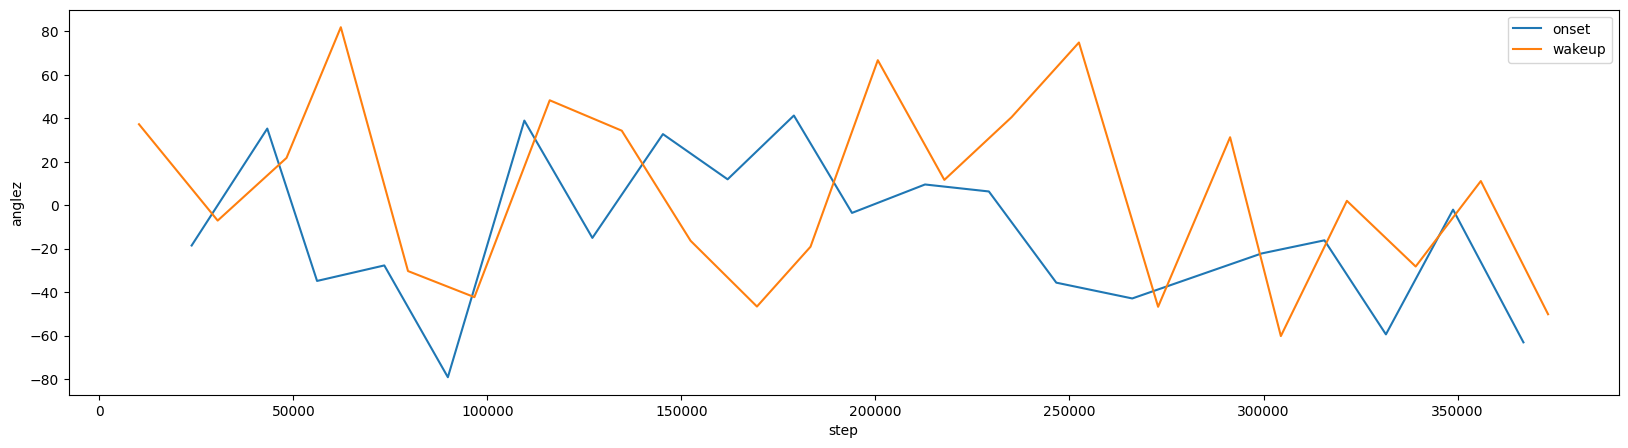

In [157]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
sns.lineplot(data=tmp.query('event == "onset"'), x='step', y='anglez', label='onset')
sns.lineplot(data=tmp.query('event == "wakeup"'), x='step', y='anglez', label='wakeup')